In [39]:
import pandas as pd
import calendar
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
import itertools
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import SimpleExpSmoothing

In [29]:
# Note this data is completely fictional. Due to privacy and confidentiality constraints, I am not able to share
# the true data. Here I will create a fictional dataset

tci_data = random.sample(range(500000, 1100000), 72)
tci_data = pd.DataFrame(sorted(tci_data), columns = ['Total TCIs'])
dates = pd.date_range('2015-01-01','2020-12-01', freq='MS')
tci_data['Date'] = dates
tci_data = tci_data.set_index('Date')
tci_data.head()

,Total TCIs
Date,
2015-01-01,510513
2015-02-01,514455
2015-03-01,515614
2015-04-01,517477
2015-05-01,521069


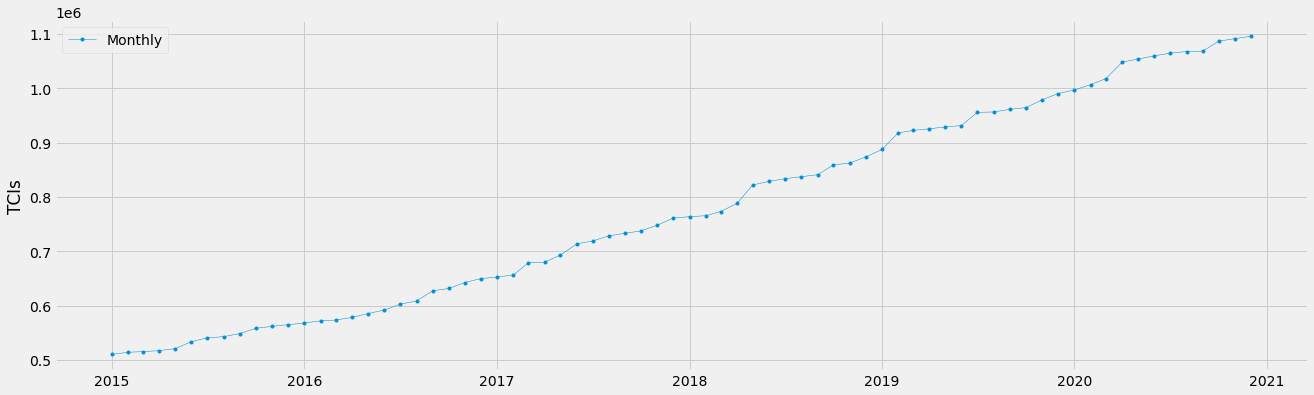

In [30]:
# plot the dataset
y = tci_data['Total TCIs']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax.set_ylabel('TCIs')
ax.legend();

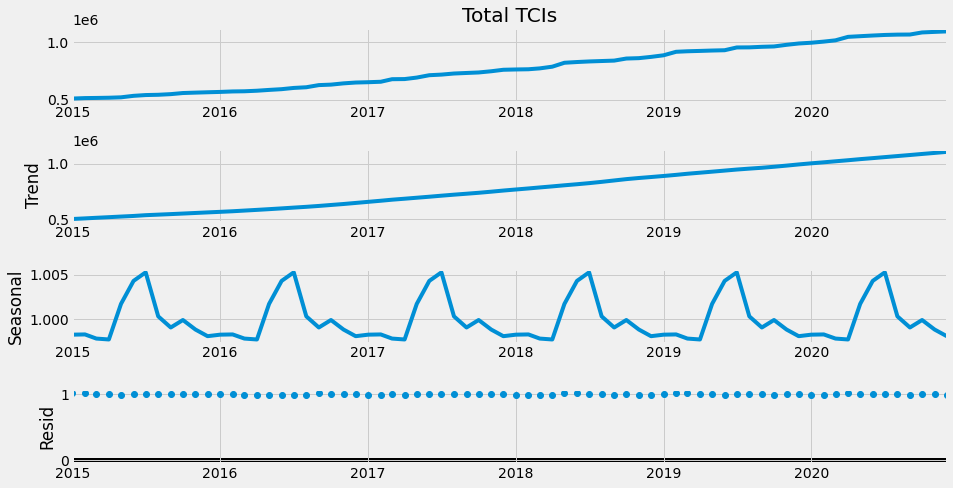

In [31]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(y)

After looking at the four pieces of decomposed graphs, I can see that the dataset has an overall increasing trend as well as yearly seasonality

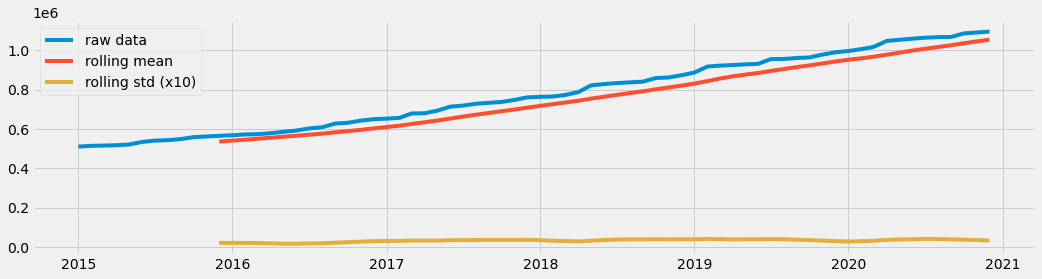

In [32]:
# plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

The mean does change over time. The standard deviation does not change much over time and remained relatively flat. Still would like to test in addition to visuals.

In [33]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 0.634
P-value = 0.988
Critical values :
	1%: -3.540522678829176 - The data is not stationary with 99% confidence
	5%: -2.9094272025108254 - The data is not stationary with 95% confidence
	10%: -2.5923136524453696 - The data is not stationary with 90% confidence


This is where my project begins to differ from the true data and this fake data. In my true data, I was able to say with 90% confidence that my data was stationary. However, I will continue with additoinal transformation methods to show what I did for my project.

 > Is the de-trended data stationary ?
Test statistic = -2.337
P-value = 0.160
Critical values :
	1%: -3.5656240522121956 - The data is not stationary with 99% confidence
	5%: -2.920142229157715 - The data is not stationary with 95% confidence
	10%: -2.598014675124952 - The data is not stationary with 90% confidence


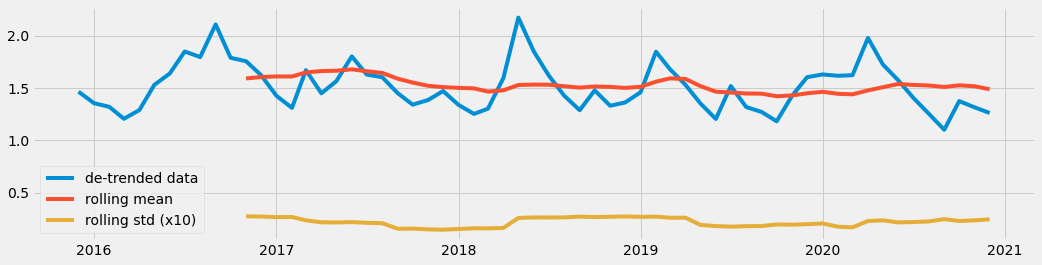

In [34]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.087
P-value = 0.028
Critical values :
	1%: -3.568485864 - The data is not stationary with 99% confidence
	5%: -2.92135992 - The data is  stationary with 95% confidence
	10%: -2.5986616 - The data is  stationary with 90% confidence


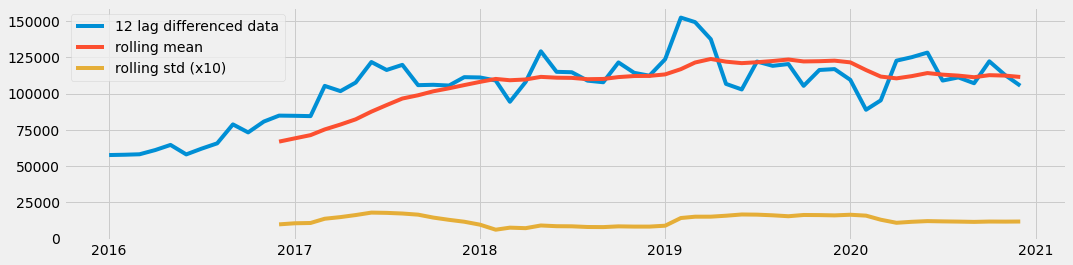

In [35]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.494
P-value = 0.008
Critical values :
	1%: -3.6209175221605827 - The data is not stationary with 99% confidence
	5%: -2.9435394610388332 - The data is  stationary with 95% confidence
	10%: -2.6104002410518627 - The data is  stationary with 90% confidence


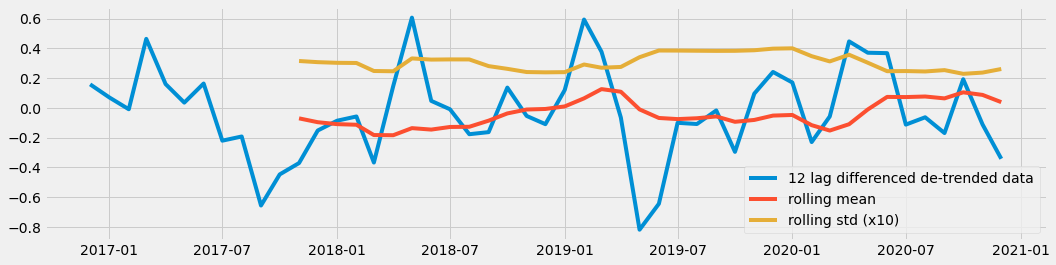

In [36]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [37]:
# split 80-20
y_to_train = y[:'2019-12-01'] # dataset to train
y_to_val = y['2020-01-01':] # last X months for test  
predict_date = len(y) - len(y[:'2020-01-01']) # the number of data points for the test set

I will be using a multiplicative model due to the upward trending of the data.

My data has a yearly seasonal pattern with 5 years of data, and we aggregated it by month. Therefore, each data point is one month, so m = 2

I will first run my data through the Holt-Winters’ Seasonal Method because it allows the forecasting of time series data that has both trend and seasonality

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=2 and a Box-Cox transformation 12609.35
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=2 and a Box-Cox transformation 12496.67


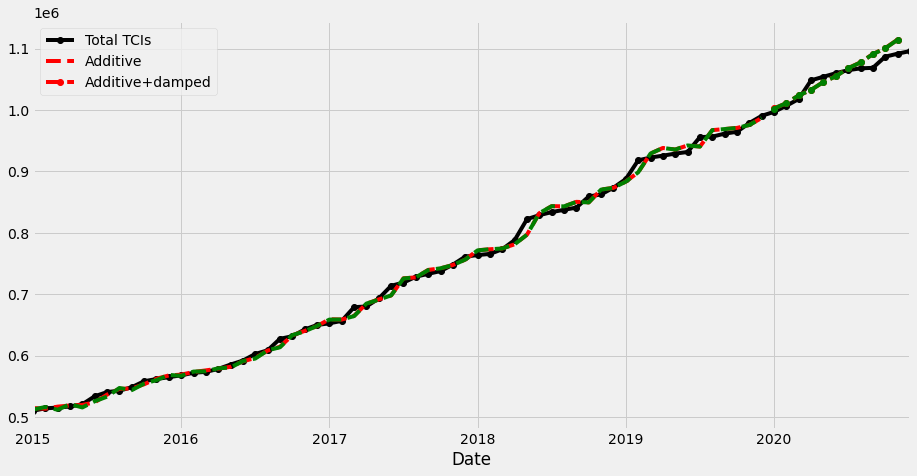

In [40]:
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()
    
holt_win_sea(y, y_to_train,y_to_val,'additive',2, predict_date)

I then ran my dataset through a SARIMA model. I had to run my data through a "gridsearch" to identify the best PDQ

In [42]:
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
sarima_grid_search(y,2)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 2) - AIC:1380.652215228217


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0236      0.211      0.112      0.911      -0.390       0.437
ar.S.L2       -0.3982      0.178     -2.235      0.025      -0.747      -0.049
ma.S.L2       -0.2296      0.131     -1.758      0.079      -0.486       0.026
sigma2      1.206e+08   4.09e-10   2.94e+17      0.000    1.21e+08    1.21e+08


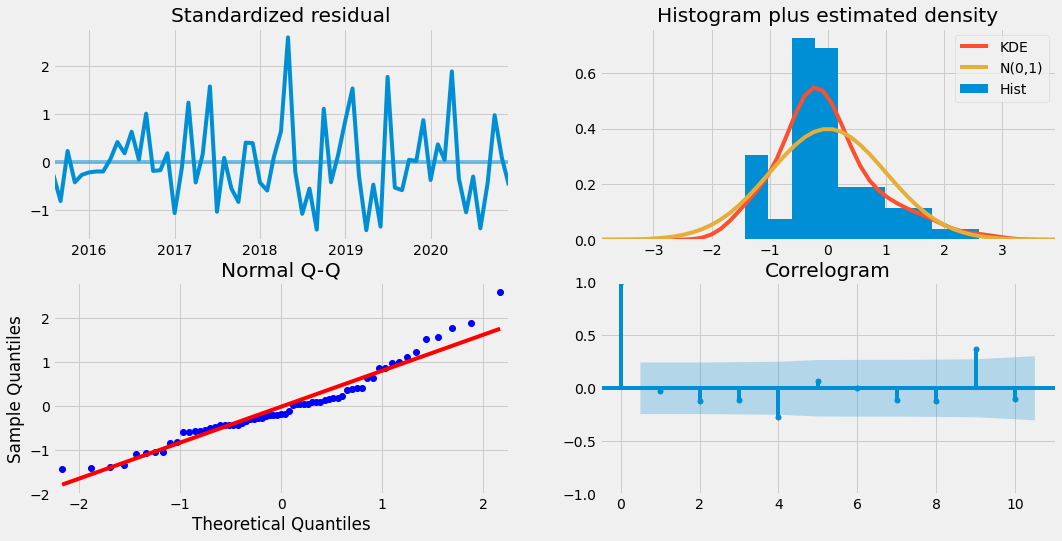

The Root Mean Squared Error of SARIMA with season_length=2 and dynamic = False 9242.26


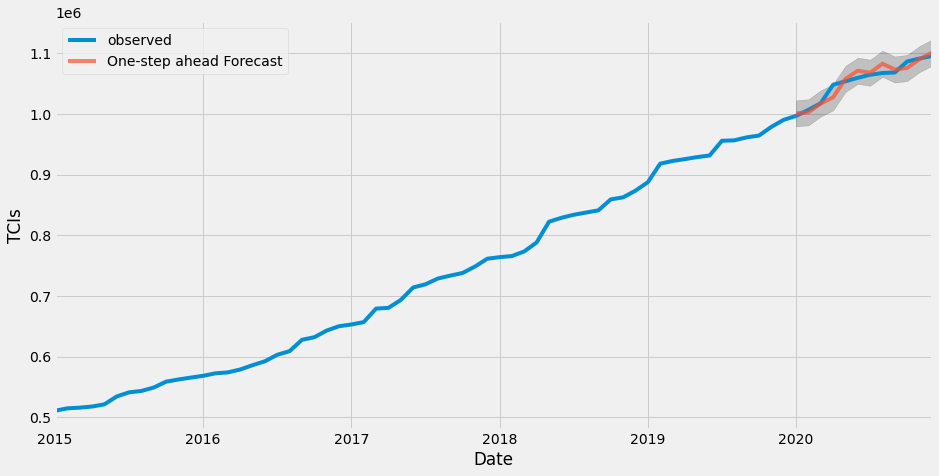

The Root Mean Squared Error of SARIMA with season_length=2 and dynamic = True 9530.43


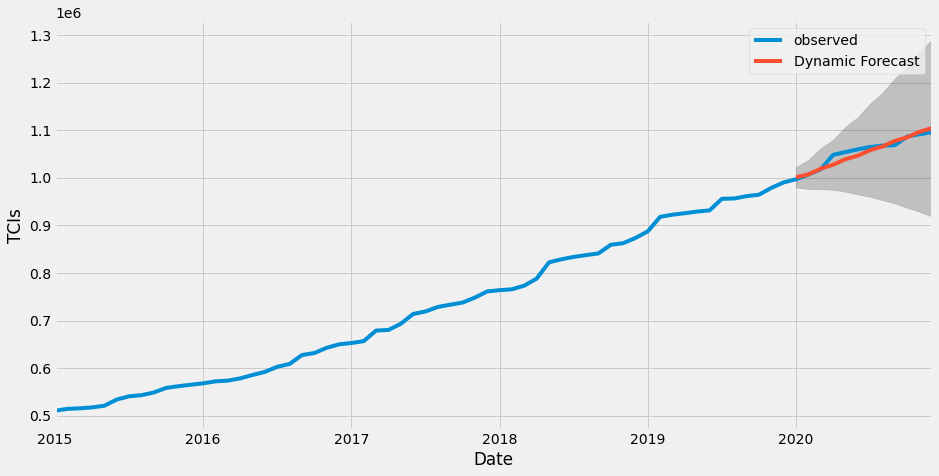

In [49]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('TCIs')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('TCIs')

    plt.legend()
    plt.show()
    
    return (results)

model = sarima_eva(y,(0,1,1),(1,1,1,2),2,'2020-01-01',y_to_val)

As you can see, the SARIMA model did a much better job at predicting the seasonality and trend than the Holt-Winters’ Seasonal Method 

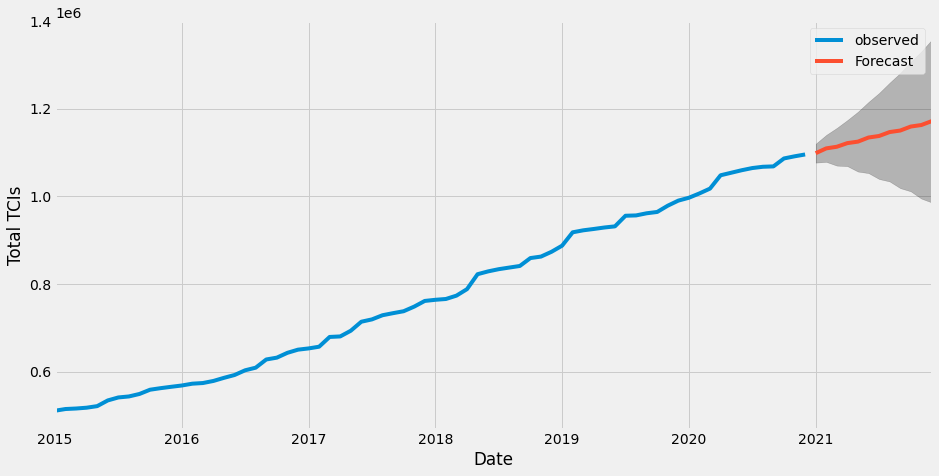

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-01-01,1098699.90443948,1077179.58699028,1120220.22188867
1,2021-02-01,1109719.70011124,1078924.70805932,1140514.69216316
2,2021-03-01,1113419.97192180,1070401.65238322,1156438.29146037
3,2021-04-01,1121742.70369125,1069167.09430750,1174318.31307500
4,2021-05-01,1125115.93872739,1056804.17620552,1193427.70124925


In [44]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

final_table = forecast(model,12,y)
final_table.head()

In [48]:
# divide the RMSE by 2020 data to see how close it is on average for the previous year

"{:.2%}".format(9242.26 / y_to_val.mean())

'0.88%'